# Chapter 6 - Structural Causal Models

The notebook is a code companion to chapter 6 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/). <a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%206/chapter_6_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written in Google Colab using Python version 3.10.12, pyro version 1.9.0, pgmpy version 0.1.25, and torch 2.3.0.

In [1]:
!pip install pyro-ppl==1.9.0
!pip install pgmpy==0.1.25
!pip install matplotlib==3.7.1

## Listing 6.1 Pyro pseudocode of the causal graphical model in Figure 6.1

Figure 6.1 in the book is a causal DAG relating femur length to height.

![A DAG mapping femur length to height](https://github.com/altdeep/causalML/blob/master/book/chapter%206/images/Figure%206_1%20femur-height-DAG.png?raw=true)

Here is how we'd model it in Pyro.

In [2]:
from pyro.distributions import Normal
from pyro import sample

def cgm_model():    #A
    x = sample("x", Normal(47., 2.3))    #A
    y = sample("y", Normal(25. + 3*x, 3.3))    #A
    return x, y    #B

#A x and y are sampled from their causal Markov kernels, in this case Normal distributions.
#B Repeatedly calling cgm_model will return samples from P(X, Y).

cgm_model()

(tensor(49.4821), tensor(170.2868))

## Listing 6.2: CGM rewritten as a SCM



We convert this model to an SCM using the following algorithm.
1.  Introduce a new latent cause parent for X called Nx and a new latent causal parent for Y called Ny with distributions P(Nx) and P(Ny)
2.  Make X and Y deterministic functions of Nx and Ny such that P(X, Y) in this new model is the same as the old model.

To convert the CGM to an SCM, we introduce a latent “exogenous” parents, Nx for X and Ny for Y, and probability distributions P(Nx) and P(Ny) for these latents. We then set X and Y deterministically given their parents via functions fx and fy.
We have two new latent variables Nx and Ny with distributions P(Nx) and P(Ny). X and Y each have their own functions fx and fy that that deterministically set X and Y given their parents in the graph. This difference is key; X and Y are generated in the model described in Figure 6.1 but set deterministically in this new model. To emphasize this, I use the assignment operator “:=”, instead of the equal sign “=” to emphasize that fx and fy assign the values of x and y.
To meet our goal of converting our CGM to an SCM, we want P(X) and P(Y|X=x) to be the same across both models. To achieve this, we have to choose P(Nx), P(Ny), fx, and fy such that P(X) is still Normal(47, 2.3) and P(Y|X=x) is still Normal(25 + 3.3x, 3.3). One option is to do a simple reparameterization. Linear functions of normally distributed random variables are also normally distributed. So we can implement the model in Figure 6.3.

![A DAG mapping femur length to height](https://github.com/altdeep/causalML/blob/master/book/chapter%206/images/Figure%206_3_rewrite_as_SCM.png?raw=true)

In code, we rewrite this as:

In [3]:
from pyro.distributions import Normal
from pyro import sample

def scm_model():
    n_x = sample("n_x", Normal(0., 2.3))    #A
    n_y = sample("n_y", Normal(0., 3.3))    #A
    x = 47. + n_x    #B
    y = 25. + 3.*x + n_y    #B
    return x, y    #C

#A We sample these new latent variables from a standard normal distribution.
#B X and Y are calculated deterministically as linear transformations of the n_x and n_y
#C The returned samples of P(X, Y) match the first model.

scm_model()

(tensor(45.3235), tensor(156.1445))

## Listing 6.3: The rock-throwing example from chapter 2 is an SCM

Consider the example our rock-throwing example from chapter 2. In this example, either Jenny or Brian or both throw a rock at window if they are inclined to do so. The window breaks depending on if either or both Jenny and Brian throw and the strength of the windowpane.
How might we convert this model to an SCM? In fact, this model is already an SCM. We captured this with the following code:


In [4]:
import pandas as pd
import random

def true_dgp(
    jenny_inclination,    #A
    brian_inclination,    #A
    window_strength):    #A
    jenny_throws_rock = jenny_inclination > 0.5    #B
    brian_throws_rock = brian_inclination > 0.5    #B
    if jenny_throws_rock and brian_throws_rock:    #C
        strength_of_impact = 0.8    #C
    elif jenny_throws_rock or brian_throws_rock:    #C
        strength_of_impact = 0.6    #C
    else:    #C
        strength_of_impact = 0.0    #C
    window_breaks = window_strength < strength_of_impact    #D
    return jenny_throws_rock, brian_throws_rock, window_breaks

generated_outcome = true_dgp(
    jenny_inclination=random.uniform(0, 1),
    brian_inclination=random.uniform(0, 1),
    window_strength=random.uniform(0, 1)
)
#A The input values are instances of "exogenous" variables.
#B Jenny and Brian throw the rock if so inclined. jenny_throws_rock and brian_throws_rock are endogenous variables.
#C strength_of_impact is an endogenous variable. This entire if-then expression is the assignment function for strength of impact.
#D window_breaks is an endogenous variable. The assignment function is `lambda strength_of_impact, window_strength: strength_of_impact > window_strength`
#E Each exogenous variable has a Uniform(0, 1) distribution.

generated_outcome

(True, True, False)

## Modeling the Monte Hall problem

A particularly useful application for SCMs is modeling rule-based systems. By “rule-based,” I mean that known rules, often set by humans, determine the “how” of causality. Games are a good example.
To illustrate, consider the Monte Hall problem. The Monty Hall problem is a probability-based brain teaser named after the host of a 1960’s game show with a similar setup.

A contestant on a game show is asked to choose between three closed doors. Behind one door is a car; behind the others, goats. The player picks the 1st door. Then the host, who knows what's behind the doors, opens another door, for example the 3rd door, which has a goat. The host then asks the contestant, "Do you want to switch to the second door, or do you want to stay with your original choice?" The question is which is the better strategy, switching doors or staying?
The correct answer is to switch doors. This question appeared in a column in Parade magazine in 1990, with the correct answer. Thousands of readers mailed in, including many with graduate-level mathematical training, to refute the answer and say that there is no advantage to switching, that staying or switching have the same probability of winning.

The following figure illustrates the intuition behind why switching is better.
![Illustration of Monte Hall Problem](https://github.com/altdeep/causalML/blob/master/book/chapter%206/images/monty_hall_illustration.png?raw=true)

Switching doors is the correct answer because under the standard assumptions, the “switch” strategy has a probability of 2/3 of winning the car, while the “stay” strategy has only a 1/3 probability. It seems counterintuitive because each door has an equal chance of having the car when the game starts. It seems as if once the host eliminates one door, each remaining door should have a 50-50 chance. This logic is false because the host doesn’t eliminate a door at random. He only eliminates a door that isn’t the players initial selection and doesn’t have the car. 1/3 of the time those are the same door, and 2/3 of that time they are different doors; that 1/3-2/3 asymmetry is why the remaining doors don’t each have a 50-50 chance of having the car.

But causal modeling makes the problem much more intuitive. We can represent this game with the following causal DAG.
![monte hall DAG](https://github.com/altdeep/causalML/blob/master/book/chapter%206/images/monte_hall_dag.png?raw=true)

The possible outcomes for each variable are as follows:

* Door with Car: Indicates the door which has the car behind it. “1st” for first door, “2nd” for the second door, “3rd” for the third door.
* Player first Choice: Indicates which door the player chooses first. “1st” for first door, “2nd” for the second door, “3rd” for the third door.
* Host Inclination: Suppose the host is facing the doors, such that from left to right they are ordered 1st, 2nd, 3rd. This Host Inclination variable has two outcomes, “Left” and “Right”. When the outcome is “Left”, the host is inclined to choose the left-most available door, otherwise he’ll be inclined to choose the right-most available door.
* Host Door Selection: The outcomes are again 1st, 2nd, and 3rd.
* Strategy: The outcomes are “switch” if the strategy is to switch doors from the first choice, or “stay” if the strategy is to stay with the first choice.
* Player Second Choice: Indicates which door the player chooses after asked by the host if they want to switch or not. The outcomes again are 1st, 2nd, and 3rd.
* Win or Lose: Indicates whether the player wins, the outcomes are “win” or “lose.” Winning occurs when Player Second Choice == Door with Car.

Next, we see how to implement this as an SCM in pgmpy. The rules of the game give us clear logic for the assignment functions. Consider for example, we can represent the assignment function for Host Door Selection with a lookup table.

When the door with the car and the player’s first choice are different doors, the host can only choose the remaining door. But if the door with the car and the player’s first choice are the same door, the host has two doors to choose from. He will choose the left most door if Host Inclination is “left.” For example, if “Door with Car” and “Player First Choice” are both 1st, the host must choose between the 2nd and 3rd door. He will choose the 2nd door if “Host Inclination”==“Left” and 3rd if “Host Inclination” == “Right”.
This logic would be straightforward to write using if-then logic with a library like Pyro. But since the rules are simple, we can use the far more constrained pgmpy library to write this function as a conditional probability table.
Conditional probability table representing functional assignment for Host Door Selection. Each probability outcome is either 0 or 1 given the causal parents, i.e., the outcome is completely deterministic given the parents.

## Listing 6.4 Implementation of Host Door Selection assignment function in pgmpy

In [5]:
from pgmpy.factors.discrete.CPD import TabularCPD
f_host_door_selection = TabularCPD(
    variable='Host Door Selection',    #A
    variable_card=3,    #B
    values=[    #C
        [0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0],    #C
        [1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1],    #C
        [0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0]    #C
    ],    #C
    evidence=[    #D
        'Host Inclination',    #D
        'Door with Car',    #D
        'Player First Choice'    #D
    ],    #D
    evidence_card=[2, 3, 3],    #E
    state_names={    #F
        'Host Door Selection':['1st', '2nd', '3rd'],    #F
        'Host Inclination': ['left', 'right'],    #F
        'Door with Car': ['1st', '2nd', '3rd'],    #F
        'Player First Choice': ['1st', '2nd', '3rd']    #F
    }    #F
)    #F
#A The name of the variable.
#B The cardinality (number of outcomes).
#C The probability table. The values match the value in the above table, as long as the ordering of the causal variables in the evidence argument matches the top-down ordering of causal variable names in the table.
#D The conditioning (causal) variables.
#E The cardinality (number of outcomes) for each conditioning (causal) variable.
#F The state names of each the variables.

This code produces f_host_door_selection , a TabularCPD object we can add to a model of the class BayesianNetwork. We can then use this as in a causal graphical model as we would a more typical TabularCPD object.

## Listing 6.5 Implementation of Player Second Choice assignment function in pgmpy

Similarly, we can create a look-up table for “Player Second Choice.”

In [6]:
from pgmpy.factors.discrete.CPD import TabularCPD
f_second_choice = TabularCPD(
    variable='Player Second Choice',
    variable_card=3,
    values=[
        [1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0],    #A
        [0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1],    #A
        [0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0]    #A
    ],
    evidence=[
        'Strategy',
        'Host Door Selection',
        'Player First Choice'
    ],
    evidence_card=[2, 3, 3],
    state_names={
        'Player Second Choice': ['1st', '2nd', '3rd'],
        'Strategy': ['stay', 'switch'],
        'Host Door Selection': ['1st', '2nd', '3rd'],
        'Player First Choice': ['1st', '2nd', '3rd']
    }
)
#A Again, the probability values are 0 or 1, so the assignment function is deterministic. In cases where the parent combinations are impossible, we still have to assign a value.

## Listing 6.6 Implementing the full Monty Hall SCM

That gives us a second TabularCPD object. We create one for each node. First, let’s setup the causal DAG.


In [7]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD

monty_hall_model = BayesianNetwork([    #A
    ('Host Inclination', 'Host Door Selection'),    #A
    ('Door with Car', 'Host Door Selection'),    #A
    ('Player First Choice', 'Host Door Selection'),    #A
    ('Player First Choice', 'Player Second Choice'),    #A
    ('Host Door Selection', 'Player Second Choice'),    #A
    ('Strategy', 'Player Second Choice'),    #A
    ('Player Second Choice', 'Win or Lose'),    #A
    ('Door with Car', 'Win or Lose')    #A
])    #A
#A Build the causal DAG.

## Listing 6.7 Create the exogenous variable distributions

`monty_hall_model` is now just a causal DAG. It will become an SCM after we add the exogenous variable distributions and assignment functions. First, we will add the exogenous variable distribution.

In [8]:
p_host_inclination = TabularCPD(       #A
    variable='Host Inclination',    #A
    variable_card=2,    #A
    values=[[.5], [.5]],    #A
    state_names={'Host Inclination': ['left', 'right']}    #A
)    #A

p_door_with_car = TabularCPD(    #B
    variable='Door with Car',    #B
    variable_card=3,    #B
    values=[[1/3], [1/3], [1/3]],    #B
    state_names={'Door with Car': ['1st', '2nd', '3rd']}    #B
)    #B

p_player_first_choice = TabularCPD(    #D
    variable='Player First Choice',    #D
    variable_card=3,    #D
    values=[[1/3], [1/3], [1/3]],    #D
    state_names={'Player First Choice': ['1st', '2nd', '3rd']}    #D
)    #D

p_host_strategy = TabularCPD(    #E
    variable='Strategy',    #E
    variable_card=2,    #E
    values=[[.5], [.5]],    #E
    state_names={'Strategy': ['stay', 'switch']}    #E
)    #E
#A A CPD for the variable Host Inclination. In cases when the player chooses the door with the car, the host has a choice between the two other doors. This variable is "left" when the host is inclined to choose the left-most door, and "right" if the host is inclined to choose the right-most door.
#B A CPD for the variable representing which door has the prize card. Assume each door has equal probability of having the car.
#D A CPD for variable representing the player's first door choice. Each door has equal probability of being chosen.
#E A CPD for variable representing the player's strategy. "Stay" is the strategy of staying with the first choice, and "switch" is the strategy of switching doors.


## Listing 6.8 Create the assignment functions

Having created the exogenous distributions, we now create the assignment functions. We’ve already created `f_host_door_selection` and `f_second_choice`, so we add `f_win_or_lose`, the assign function determining whether the player wins or loses.

In [9]:
f_win_or_lose = TabularCPD(    #H
    variable='Win or Lose',    #H
    variable_card=2,    #H
    values=[    #H
        [1,0,0,0,1,0,0,0,1],    #H
        [0,1,1,1,0,1,1,1,0],    #H
    ],    #H
    evidence=['Player Second Choice', 'Door with Car'],    #H
    evidence_card=[3, 3],    #H
    state_names={    #H
        'Win or Lose': ['win', 'lose'],    #H
        'Player Second Choice': ['1st', '2nd', '3rd'],    #H
        'Door with Car': ['1st', '2nd', '3rd']    #H
    }    #H
)    #H
#H Structural assignment function for whether the player wins or loses.

## Listing 6.9 Create the SCM for the Monty Hall problem

Finally, we add the exogenous distribution and the assignment functions to monty_hall_model and creating the SCM.

In [10]:
monty_hall_model.add_cpds(    #I
    p_host_inclination,    #I
    p_door_with_car,    #I
    p_player_first_choice,    #I
    p_host_strategy,    #I
    f_host_door_selection,    #I
    f_second_choice,    #I
    f_win_or_lose    #I
)    #I
#I Add the CPDs to the causal DAG.

## Listing 6.10 Inferring the winning strategy

We can run the variable elimination inference algorithm to verify the results of the algorithm. We can query the probability of winning given the player takes the “stay” strategy. The probability of winning and losing under the “stay” strategy is 1/3 and 2/3, respectively. In contrast, the probability of winning and losing under the “switch” strategy is 2/3 and 1/3, respectively. Related we can condition on the outcome and infer the probability that each strategy leads to that outcome. The switch strategy has a 2/3 probability of having been the strategy the player chose.


In [11]:
from pgmpy.inference import VariableElimination    #A

infer = VariableElimination(monty_hall_model)
q1 = infer.query(['Win or Lose'], evidence={'Strategy': 'stay'})    #B
print(q1)    #B
q2 = infer.query(['Win or Lose'], evidence={'Strategy': 'switch'})    #C
print(q2)    #C
q3 = infer.query(['Strategy'], evidence={'Win or Lose': 'win'})    #D
print(q3)    #D
#A We’ll use the graphical inference algorithm variable elimination for inference.
#B Print the probabilities of winning and losing given the player uses the “stay” strategy.
#C Print the probabilities of winning and losing given the player uses the “switch” strategy.
#D Print the probabilities that the player used a stay strategy versus a switch strategy, given the player won.

+-------------------+--------------------+
| Win or Lose       |   phi(Win or Lose) |
+===================+====================+
| Win or Lose(win)  |             0.3333 |
+-------------------+--------------------+
| Win or Lose(lose) |             0.6667 |
+-------------------+--------------------+
+-------------------+--------------------+
| Win or Lose       |   phi(Win or Lose) |
+===================+====================+
| Win or Lose(win)  |             0.6667 |
+-------------------+--------------------+
| Win or Lose(lose) |             0.3333 |
+-------------------+--------------------+
+------------------+-----------------+
| Strategy         |   phi(Strategy) |
+==================+=================+
| Strategy(stay)   |          0.3333 |
+------------------+-----------------+
| Strategy(switch) |          0.6667 |
+------------------+-----------------+


## Listing 6.11 Pyro example of a linear Gaussian model

In a linear Gaussian additive model, the assignment functions are linear functions of the parents, and the exogenous variables have a normal distribution. In our enzyme example, $N_y$ and Y are given as follows:

$$n_y \sim N(0, \sigma_y)$$
$$y:=\beta_0 + \beta_x + n_y$$

Here $\beta_0$ is an intercept term and $\beta_x$ is a coefficient for X. Here, we are assuming that for every unit increase in the amount of enzyme X, there is an βx increase in the expected amount of the measured protein. $N_y$ accounts for variation around that expected amount due to exogenous causal factors, and we assume it has a normal distribution with mean 0 and scale parameter $\sigma_y$. For example, we might assume that $N_y$ is comprised mostly of technical noise from the measurement device, such as dust particles that interfere with the sensors. We might know from experience with this device that this noise has a normal distribution.

In general, for variable V with a set of K parents $V_{PA} = \{ V_{\text{pa},1}, …,  V_{\text{pa},k} \} $:

$$n_y \sim N(0\sigma_y)$$

$$ v:= \beta_0 + \sum_j \beta_x v_{\text{pa},j} + n_y $$

This model defines parameters $\beta_0$ is an intercept term, the $\beta_j$ is the coefficient attached to the jth parent. $\sigma_v$ is the scale parameter of the $N_v$’s normal distribution.



In [12]:
from pyro import sample
from pyro.distributions import Normal

def linear_gaussian():
    n_x = sample("N_x", Normal(9., 3.))
    n_y = sample("N_y", Normal(9., 3.))
    x = 10. + n_x    #A
    y = 2. * x + n_y    #B
    return x, y
#A The distributions of the exogenous variables are normal (Gaussian)
#B The functional assignments are linear.


## Listing 6.12: Pyro example of a LiNGAM model

LiNGAM models are useful when the Gaussian assumption on exogenous variables is not appropriate. In our example, the amount of protein Y cannot be negative, but in a linear model that can easily occur if $\beta_0$, x, and $n_x$ have low values. LiNGAM models remedy this by allowing the exogenous variable to have a non-normal distribution.


In [13]:
from pyro import sample
from pyro.distributions import Gamma

def LiNGAM():
    n_x = sample("N_x", Gamma(9., 1.))    #A
    n_y = sample("N_y", Gamma(9., 1.))    #A
    x = 10. + n_x    #B
    y = 2. * x + n_y    #B
    return x, y
#A Instead of a normal (Gaussian) distribution, the exogenous variables have a gamma distribution with the same mean and variance.

## Listing 6.13 Build the enzyme data with PyTorch

First let's build an enzyme model.


In [14]:
from torch import nn

class EnzymeModel(nn.Module):    #A
    def __init__(self):
        super().__init__()
        self.β = nn.Parameter(torch.randn(1, 1))    #B

    def forward(self, x):
        x = torch.mul(x, self.β)    #C
        x = x.log().sigmoid()    #D
        x = torch.mul(x, 100.)    #E
        return x
#A Create the enzyme model.
#B Initialize the parameter β.
#C Multiple enzyme amount X and β.
#D Implement the function u / (u + 1) as sigmoid(log(u)), since the sigmoid and log functions are native Pytorch transforms.
#E Multiply by T = 100.

## Listing 6.14 Train the enzyme model

Now, we'll try to learn $\beta$ from this data using a basic PyTorch workflow.


In [15]:
import pandas as pd
from torch import tensor
import torch

df = pd.read_csv("https://raw.githubusercontent.com/altdeep/causalML/master/datasets/enzyme-data.csv")   #A
X = torch.tensor(df['x'].values).unsqueeze(1).float()    #B
Y = torch.tensor(df['y'].values).unsqueeze(1).float()    #B

def train(X, Y, model, loss_function, optim, num_epochs):    #C
    loss_history = []    #C
    for epoch in range(num_epochs):    #C
        Y_pred = model(X)    #C
        loss = loss_function(Y_pred, Y)    #C
        loss.backward()    #C
        optim.step()    #C
        optim.zero_grad()    #C
        if epoch % 1000 == 0:    #D
            print(round(loss.data.item(), 6))    #D

torch.manual_seed(1)    #E
enzyme_model = EnzymeModel()
optim = torch.optim.Adam(enzyme_model.parameters(), lr=0.00001)    #F
loss_function = nn.MSELoss()    #G

train(X, Y, enzyme_model, loss_function, optim, num_epochs=60000)
#A Load the enzyme data from Github.
#B Convert the data to tensors.
#C Create the training algorithm.
#D Print out losses during training.
#E Set a random seed for reproducibility
#F Initialize an instance of Adam optimizer. Use a low value of the learning rate because loss is very sensitive to small changes in β.
#G Using mean squared loss error is equivalent to assuming Ny is additive and symetric.

628.438416
623.832031
619.098694
614.248352
609.275696
604.196472
599.006653
593.702759
588.28064
582.736084
577.064819
571.23999
565.265564
559.148254
552.882629
546.462952
539.883423
533.137512
526.218872
519.120483
511.834991
504.354675
496.671631
488.7771
480.649445
472.279724
463.668854
454.806274
445.680756
436.28064
426.593781
416.604309
406.274323
395.615417
384.612854
373.251648
361.516296
349.391022
336.860077
323.908081
310.520355
296.66571
282.351013
267.583984
252.345642
236.663025
220.552872
204.061569
187.260803
170.258209
153.219879
136.384979
120.099098
104.845779
91.277863
80.207985
72.464417
68.422508
67.238739
67.121902


## Listing 6.15 Fitting β in the enzyme model with a probabilistic model and Bayesian inference

The problem with this approach is that the SCM should encode a distribution P(X, Y). So we can turn to a probabilistic modeling approach to fit this model.


In [16]:
import pyro
from pyro.distributions import Beta, Normal, Uniform
from pyro.infer.mcmc import NUTS, MCMC

def g(u):    #A
  return u / (1 + u)    #A

def model(N):    #B
    β = pyro.sample("β", Beta(0.5, 5.0))    #C
    with pyro.plate("data", N):    #D
        x = pyro.sample("X", Uniform(0.0, 101.0))     #E
        y = pyro.sample("Y", Normal(100.0 * g(β * x), x**.5))    #F
    return x, y

conditioned_model = pyro.condition(    #G
    model,    #G
    data={"X": X.squeeze(1), "Y":  Y.squeeze(1)}    #G
)    #G

N = X.shape[0]    #H
pyro.set_rng_seed(526)    #I
nuts_kernel = NUTS(conditioned_model, adapt_step_size=True)    #J
mcmc = MCMC(nuts_kernel, num_samples=1500, warmup_steps=500)    #J
mcmc.run(N)    #J
#A The simple transform used in the assignment function for Y (amount of target protein).
#B The probabilistic model.
#C A prior on the parameter β that we mean to fit with this model
#D A “plate” for the N=100 identical and independently distributed object.
#E The marginal probability of the enzyme P(X) is a uniform distribution between 0 and 101.
#F P(Y|X), the conditional distribution of Y (protein concentration) given X (and β). I model P(Y|X) with a normal distribution with both a mean and variance that depends on Y.
#G Condition the model on the observed evidence.
#H Get the number of examples in the data (100).
#I Set a random seed for reproducibility.
#J To learn β, I use a gradient-based MCMC algorithm called a No-U-Turn Sampler (NUTS). Note this algorithm is one of many probabilistic approaches for parameter learning, and this choice is independent of the causal elements of your model.


Sample: 100%|██████████| 2000/2000 [00:16, 120.16it/s, step size=8.86e-01, acc. prob=0.945]


## Listing 6.16 Initializing splines for assignment functions

Next, we model the SCM using normalizing flows. Normalizing flows model a complex probability density as an invertible transformation of a simple base density. I’m going to use flows to model the distribution of endogenous variables as invertible transformations of exogenous variable distributions. There are many different transformations, I’m going to use neural splines. Splines are a decades-old approach to curve-fitting using piece-wise polynomials, a neural spline is the neural network version of a spline.

In [17]:
from pyro.distributions.transforms import conditional_spline
print(conditional_spline(input_dim=1, context_dim=1))    #A
#A A neural spline transform is a type of invertible PyTorch neural network module

ConditionalSpline(
  (nn): DenseNN(
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=31, bias=True)
    )
    (f): ReLU()
  )
)


## Listing 6.17: Transforming distribution of Nx to distribution of X

Normalizing flows solve our problem of not having a likelihood value for `y = f(x, ny)`. Like other probabilistic machine learning models, they allow you to connect an input random variable (like an exogenous variable) to an output variable (like an endogenous variable) using layers of transformations. The key difference is normalizing flow models automatically calculate the probability values of instances of the output variable in the data (using the change-of-variable formula from probability theory). For example, in the following code, `NxDist` is the distribution of exogenous variable Nx. I set the distribution as a `Uniform(0, 1)`. `f_x` is the assignment function for X, implemented as an `AffineTransformation` that maps this distribution to `Uniform(1, 101)`.

In [18]:
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import AffineTransform


NxDist = Uniform(torch.zeros(1), torch.ones(1))     #A
f_x = AffineTransform(loc=1., scale=100.0)    #B
XDist = TransformedDistribution(NxDist, [f_x])    #C
#A The exogenous distribution of X is Uniform(0, 1).
#B The assignment function for f_x. The AffineTransform multiplies Nx by 100 and adds 1.
#C XDist is an explicit representation of P(X). Multiplying by 100 and adding 1 gives you a Uniform(1, 101).


## Listing 6.18 Specify the Flow-based SCM

Let's specify the full model.

In [19]:
import pyro
from pyro.distributions import (
    ConditionalTransformedDistribution,
    Normal, Uniform,
    TransformedDistribution
)
from pyro.distributions.transforms import (
    conditional_spline, spline
)
import torch
from torch.distributions.transforms import AffineTransform

pyro.set_rng_seed(348)

NxDist = Uniform(torch.zeros(1), torch.ones(1))     #A
f_x = AffineTransform(loc=1., scale=100.0)    #B
XDist = TransformedDistribution(NxDist, [f_x])    #C

NyDist = Normal(torch.zeros(1), torch.ones(1))    #D
f_y = conditional_spline(input_dim=1, context_dim=1)    #E
YDist = ConditionalTransformedDistribution(NyDist, [f_y])    #F
#A The exogenous distribution of X is Uniform(0, 1).
#B The assignment function for f_x. The AffineTransform multiplies Nx by 100 and adds 1.
#C XDist is an explicit representation of P(X). Multiplying by 100 and adding 1 gives you a Uniform(1, 101).
#D The exogenous distribution of Y is Normal(0, 1).
#E We implement the assignment function for f_y with a neural spline. Optimization will optimize the parameters of this spline.
#F YDist is an explicit representation of P(Y|X).

## Listing 6.19 Train the SCM

Now run the training.

Text(0, 0.5, 'loss')

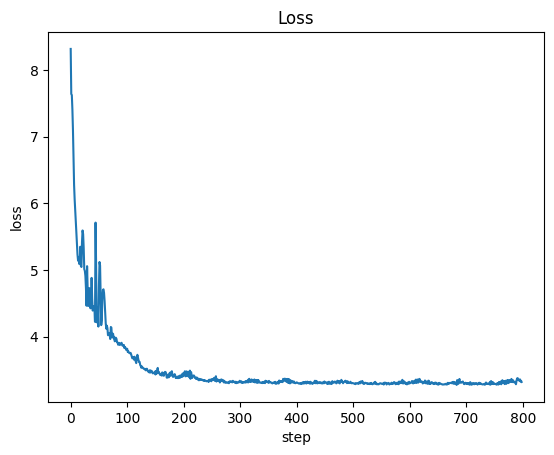

In [20]:
import matplotlib.pyplot as plt

modules = torch.nn.ModuleList([f_y])    #A
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)    #B
losses = []
maxY = max(Y)    #C
Ynorm = Y / maxY    #C
for step in range(800):
    optimizer.zero_grad()    #D
    log_prob_x = XDist.log_prob(X)    #E
    log_prob_y = YDist.condition(X).log_prob(Ynorm)    #F
    loss = -(log_prob_x + log_prob_y).mean()    #G
    loss.backward()    #G
    optimizer.step()    #G
    XDist.clear_cache()
    YDist.clear_cache()
    losses.append(loss.item())

plt.plot(losses[1:])    #H
plt.title("Loss")    #H
plt.xlabel("step")    #H
plt.ylabel("loss")    #H

#A Register the neural spline functional assignment function for Y.
#B Initialize the optimizer.
#C Normalize Y since the assignment function is working with neural networks.
#D Set all gradients to 0.
#E Use P(X) to calculate a log likelihood value for each value of X.
#F Use P(Y|X) to calculate a log likelihood value for each value of Y given X.
#G Fit the parameters of the neural network modules using maximum likelihood as an objective.
#H Visualize losses during training.

## Listing 6.20: Generate from the trained model

Now we generate samples from the model and compare them to the training data.

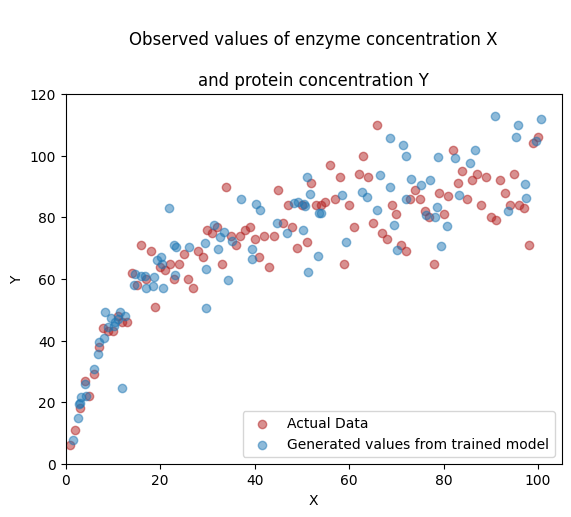

In [21]:
x_flow = XDist.sample(torch.Size([100,]))    #A
y_flow = YDist.condition(x_flow).sample(torch.Size([100,])) * maxY    #A

plt.title("""
Observed values of enzyme concentration X\n
and protein concentration Y""")    #B
plt.xlabel('X')    #B
plt.ylabel('Y')    #B
plt.xlim(0, 105)    #B
plt.ylim(0, 120)    #B
plt.scatter(    #B
    X.squeeze(1), Y.squeeze(1), color='firebrick',    #B
    label='Actual Data',    #B
    alpha=0.5    #B
)    #B
plt.scatter(    #B
    x_flow.squeeze(1), y_flow.squeeze(),    #B
    label='Generated values from trained model',    #B
    alpha=0.5    #B
)    #B
plt.legend()    #B
plt.show()    #B
#A Generate synthetic examples from the trained model.
#B Visualize the synthetic examples over the examples in the training data to validate model fit.